In [1]:
!git clone https://github.com/openai/CLIP.git
# CLIP: Contrastive Language-Image Pre-Training
# Learning Transferable Visual Models From Natural Language Supervision (paper)

!git clone https://github.com/CompVis/taming-transformers.git
# Taming Transformers for High-Resolutions Image Synthesis (paper)

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.93 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
# install some extra libraries

!pip install --no-deps ftfy regex tqdm  # install text fixing, regex, and progress bar libraries without dependencies
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8  # install specific versions for configuration and training framework
!pip uninstall torchtext --yes  # remove torchtext as it may conflict or is not needed
!pip install einop  # install einop, a lightweight wrapper for Einstein summation operations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
# import libraries

import numpy as np  # numerical operations and arrays
import torch, os, imageio, pdb, math  # torch for deep learning, os for file paths, imageio for reading/writing images, pdb for debugging, math for mathematical functions
import torchvision  # PyTorch vision utilities
import torchvision.transforms as T  # image transformations
import torchvision.transforms.functional as TF  # functional image transformations

import PIL  # Python Imaging Library for handling images
import matplotlib.pyplot as plt  # plotting and visualisation

import yaml  # for reading YAML configuration files
from omegaconf import OmegaConf  # structured configuration management

from CLIP import clip  # import CLIP model (Contrastive Language–Image Pretraining)

# import warnings
# warnings.filterwarnings('ignore')  # (optional) suppress warnings


In [4]:
# helper functions

def show_from_tensor(tensor):
  img = tensor.clone()  # create a copy of the tensor
  img = img.mul(255).byte()  # scale pixel values from [0,1] to [0,255] and convert to byte type
  img = img.cpu().numpy().transpose((1, 2, 0))  # move to CPU and change to H x W x C format for plotting

  plt.figure(figsize=(10, 7))  # set figure size
  plt.axis('off')  # remove axes for clean display
  plt.imshow(img)  # show image
  plt.show()

def norm_data(data):
  return (data.clip(-1, 1) + 1) / 2  # clip values to [-1, 1] and normalise to [0, 1] range

# parameters

learning_rate = 0.5  # learning rate for the optimiser
batch_size = 1  # number of samples per training iteration
wd = 0.1  # weight decay (regularisation parameter)
noise_factor = 0.1  # scale of noise added to the image

total_iter = 100  # total number of optimisation steps
im_shape = [225, 400, 3]  # image dimensions: height, width, channels
size1, size2, channels = im_shape  # unpack image dimensions


In [5]:
### clip model ###

clipmodel, _ = clip.load("ViT-B/32", jit = False)  # load the CLIP model with Vision Transformer (ViT-B/32) architecture
clipmodel.eval()  # set the model to evaluation mode
print(clip.available_models())  # print all available CLIP model variants

print("CLIP model visual input resolution: ", clipmodel.visual.input_resolution)  # display expected image resolution

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # choose GPU if available, else CPU
torch.cuda.empty_cache()  # clear unused GPU memory

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.6MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
CLIP model visual input resolution:  224


In [6]:
## taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

/content/taming-transformers
--2025-05-09 08:24:03--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/2b6d1c4f-ca42-4040-b5f4-f860316508e0/last.ckpt [following]
--2025-05-09 08:24:04--  https://heibox.uni-heidelberg.de/seafhttp/files/2b6d1c4f-ca42-4040-b5f4-f860316508e0/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  11.2MB/s    in 92s     

2025-05-09 08:25:36 (10.2 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [7]:
np.Inf = np.inf  # patch legacy attribute for libraries that still use np.Inf

ModuleNotFoundError: No module named 'torch._six'

To solve it, do the following:

1.   Inside google colab, open the file located at: /content/taming-transformers/taming/data/utils.py

2.  Comment out the following line: *#from torch._six import string_classes*

3.  Then, a little above that line, add the following line: *string_classes=str*

Make sure the changed file is saved, and run the cell again and it will work all perfectly.


In [9]:
from taming.models.vqgan import VQModel  # import the VQModel class from the taming VQGAN implementation

def load_config(config_path, display=False):
    config_data = OmegaConf.load(config_path)  # load configuration file
    if display:
        print(yaml.dump(OmegaConf.to_container(config_data)))  # optionally print config content
    return config_data  # return the configuration object

def load_vqgan(config, ckpt_path=None):  # corrected function name and argument
    model = VQModel(**config.model.params)  # initialise the VQGAN model with parameters from the config
    if ckpt_path is not None:
        state_dict = torch.load(ckpt_path, map_location="cpu", weights_only=False)["state_dict"]  # load model weights from checkpoint
        missing, unexpected = model.load_state_dict(state_dict, strict=False)  # allow missing/unexpected keys
    return model.eval()  # set to evaluation mode and return the model

def generator(x):  # decode a latent tensor using the VQGAN decoder
    x = taming_model.post_quant_conv(x)  # apply post-quantisation convolution
    x = taming_model.decoder(x)  # decode to image space
    return x  # return the generated image tensor

# load VQGAN configuration and model
taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, ckpt_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device) # move model to GPU/CPU


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 136MB/s]


8.19kB [00:00, 524kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [10]:
# declare the values that we are going to optimise

class Parameters(torch.nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        self.data = .5 * torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x25 (225//16, 400/16)
        self.data = torch.nn.Parameter(torch.sin(self.data))

    def forward(self):
        return self.data

def init_params():
  params = Parameters().cuda()
  optimiser = torch.optim.AdamW([{'params': [params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimiser

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


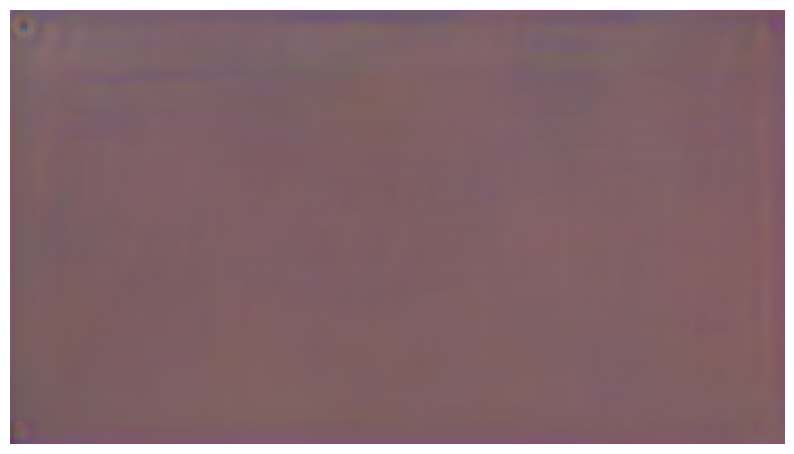

In [11]:
### encoding prompts and a few more things

# normalisation parameters for CLIP image inputs (mean and std dev for each channel)
normalise = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                              (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t = clip.tokenise(text).cuda()  # tokenise and move to GPU
  t = clipmodel.encode_text(t).detach().clone()  # encode text and detach from computation graph
  return t  # return encoded text tensor

def createEncodings(include, exclude, extras):
  include_enc = []
  for text in include:  # encode each included prompt
    include_enc.append(encodeText(text))
  exclude_enc = encodeText(exclude) if exclude != '' else 0  # encode excluded prompt if provided
  extras_enc = encodeText(extras) if extras != '' else 0  # encode extras prompt if provided

  return include_enc, exclude_enc, extras_enc  # return encoded representations

# data augmentation pipeline for training-time image variation
augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),  # random horizontal flip
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)  # random affine transformation with 30° rotation and 20% translation
).cuda()

# initialise learnable image parameters and optimiser (you need to define init_params())
Params, optimiser = init_params()

# visualise the current image without affecting gradients
with torch.no_grad():
  print(Params().shape)  # print the shape of the learnable parameter tensor
  img = norm_data(generator(Params()).cpu())  # decode the image and normalise it to [0, 1]
  print("img dimensions: ", img.shape)  # print the image dimensions
  show_from_tensor(img[0])  # display the image


In [12]:
# create crops

def create_crops(img, num_crops=30):
  p = size1/2
  img = torch.nn.functional.pad(img, (p, p, p, p), mode = 'constant', value = 0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  # apply those transformations
  img = augTransform(img) # random horizontal flip and random affine transformations

  # creating crop set
  crop_set = []
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
    gap2 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1), ())
    offsety = torch.randint(0, int(size1*2-gap1), ())

    #actual cropping
    crop = img[:, :, offsetx:offsetx+gap2, offsety:offsety+gap2]

    #resize the crops
    crop = torch.nn.functional.interpolate(crop, (224, 224), mode = 'bilinear', align_corners = True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set,0) # 30 x 3 x 224 x 224

  img_crops = img_crops + noise_factor*torch.randn_like(img_crops, requires_grad = False)

  return img_crops

In [14]:
# show current state of generation

def show(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if(show_crop):
      print("Augmented cropped example:")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops = 1) # 30 x 3 x 224 x 224
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

      print("Generation")
      latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
      show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [15]:
# optimisation process

def optimise_result(Params, prompt):
  alpha = 1 # importance of the include encodings
  beta = .5 # importance of the exclude encodings

  # to calculate the loss, we need to compare encodings of the image crops generated from the current state of our latent space parameters.
  # that's why we first need to pass our parameters through the generator to generate an image that can encode.

  # image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalise(out) # 30 x 3 x 224 x 224
  image_enc = clipmodel.encode_image(out) # 30 x 512

  # text encoding w1 and w2 (weight of the include text encoding versus the extras)
  final_enc = w1 * prompt + w1 * extras_enc # prompt and extrac_enc: 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim = -1, keepdim = True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  # calculate the loss
  min_loss = torch.cosine_similarity(final_text_include_enc, image_enc, dim = -1)# 30
  penalise_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha * min_loss + beta * penalise_loss

  return final_loss

def optimise(Params, optimiser, prompt):
  loss = optimise_result(Params, prompt.mean()) # calculate current loss
  optimiser.zero_grad() # set gradients to zero
  loss.backward() # backpropogation
  optimiser.step()
  return loss